# Gated Recurrent Units (GRU) 

In [1]:
!pip install pandas numpy matplotlib seaborn  scikit-learn xgboost importlib bayesian-optimization 


In [172]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dropout, Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [173]:
maindf = pd.read_csv('/home/ariyaman/learntocode/Stockipy/data/historical_stock_data_SBIN.csv')
maindf

,DATE,SERIES,OPEN,HIGH,LOW,PREV. CLOSE,LTP,CLOSE,VWAP,52W H,52W L,VOLUME,VALUE,NO OF TRADES,SYMBOL
0,2024-06-27,EQ,843.90,847.40,838.25,845.35,845.00,844.00,843.39,912.00,543.2,20378887,1.718741e+10,320327,SBIN
1,2024-06-26,EQ,839.85,848.80,836.00,842.25,844.25,845.35,843.76,912.00,543.2,16281760,1.373787e+10,236219,SBIN
2,2024-06-25,EQ,837.00,845.85,834.30,832.70,841.95,842.25,841.30,912.00,543.2,20917530,1.759790e+10,278788,SBIN
3,2024-06-24,EQ,831.50,836.00,821.05,836.30,833.50,832.70,829.99,912.00,543.2,12715254,1.055357e+10,229601,SBIN
4,2024-06-21,EQ,844.90,848.05,828.60,843.75,834.45,836.30,837.22,912.00,543.2,18990090,1.589888e+10,305592,SBIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,2013-01-07,EQ,2490.00,2499.00,2461.75,2486.70,2465.00,2467.60,2481.24,2499.00,1625.1,1026449,2.546866e+09,48683,SBIN
2852,2013-01-04,EQ,2460.00,2492.95,2450.65,2471.60,2490.00,2486.70,2475.69,2492.95,1611.4,1370595,3.393164e+09,62637,SBIN
2853,2013-01-03,EQ,2460.00,2482.40,2436.20,2450.55,2470.70,2471.60,2465.12,2482.40,1611.4,2010309,4.955653e+09,71411,SBIN
2854,2013-01-02,EQ,2450.00,2464.00,2438.15,2426.45,2451.90,2450.55,2453.53,2475.00,1611.4,1466012,3.596900e+09,61823,SBIN


In [174]:
maindf = maindf.rename(columns={'DATE': 'date','OPEN':'open','HIGH':'high','LOW':'low','CLOSE':'close',
                                'PREV. CLOSE':'prev_close','VOLUME':'volume'})
maindf.head()

,date,SERIES,open,high,low,prev_close,LTP,close,VWAP,52W H,52W L,volume,VALUE,NO OF TRADES,SYMBOL
0,2024-06-27,EQ,843.90,847.40,838.25,845.35,845.00,844.00,843.39,912.0,543.2,20378887,1.718741e+10,320327,SBIN
1,2024-06-26,EQ,839.85,848.80,836.00,842.25,844.25,845.35,843.76,912.0,543.2,16281760,1.373787e+10,236219,SBIN
2,2024-06-25,EQ,837.00,845.85,834.30,832.70,841.95,842.25,841.30,912.0,543.2,20917530,1.759790e+10,278788,SBIN
3,2024-06-24,EQ,831.50,836.00,821.05,836.30,833.50,832.70,829.99,912.0,543.2,12715254,1.055357e+10,229601,SBIN
4,2024-06-21,EQ,844.90,848.05,828.60,843.75,834.45,836.30,837.22,912.0,543.2,18990090,1.589888e+10,305592,SBIN


In [175]:
print("Total number of days: ",maindf.shape[0])
print("Total number of fields: ",maindf.shape[1])

Total number of days:  2856
Total number of fields:  15


In [176]:
print("Null values:", maindf.isnull().values.sum())
print("NA values:", maindf.isna().values.any())

Null values: 0
NA values: False


In [177]:
# convert date field from string to Date format 
maindf['date'] = pd.to_datetime(maindf.date)
maindf.head()

,date,SERIES,open,high,low,prev_close,LTP,close,VWAP,52W H,52W L,volume,VALUE,NO OF TRADES,SYMBOL
0,2024-06-27,EQ,843.90,847.40,838.25,845.35,845.00,844.00,843.39,912.0,543.2,20378887,1.718741e+10,320327,SBIN
1,2024-06-26,EQ,839.85,848.80,836.00,842.25,844.25,845.35,843.76,912.0,543.2,16281760,1.373787e+10,236219,SBIN
2,2024-06-25,EQ,837.00,845.85,834.30,832.70,841.95,842.25,841.30,912.0,543.2,20917530,1.759790e+10,278788,SBIN
3,2024-06-24,EQ,831.50,836.00,821.05,836.30,833.50,832.70,829.99,912.0,543.2,12715254,1.055357e+10,229601,SBIN
4,2024-06-21,EQ,844.90,848.05,828.60,843.75,834.45,836.30,837.22,912.0,543.2,18990090,1.589888e+10,305592,SBIN


In [178]:
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  2024-06-27 00:00:00
Ending date:  2013-01-01 00:00:00
Duration:  -4195 days +00:00:00


/tmp/ipykernel_13991/881471916.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_13991/881471916.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_13991/881471916.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [179]:
monthvise= maindf.groupby(maindf['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
date,,
January,672.176834,670.373359
February,621.825000,619.530533
March,606.185771,606.280237
April,657.293142,658.344912
May,713.758431,712.981765
June,697.909960,697.128685
July,693.687917,691.714167
August,633.880837,632.003524
September,675.905556,675.111556


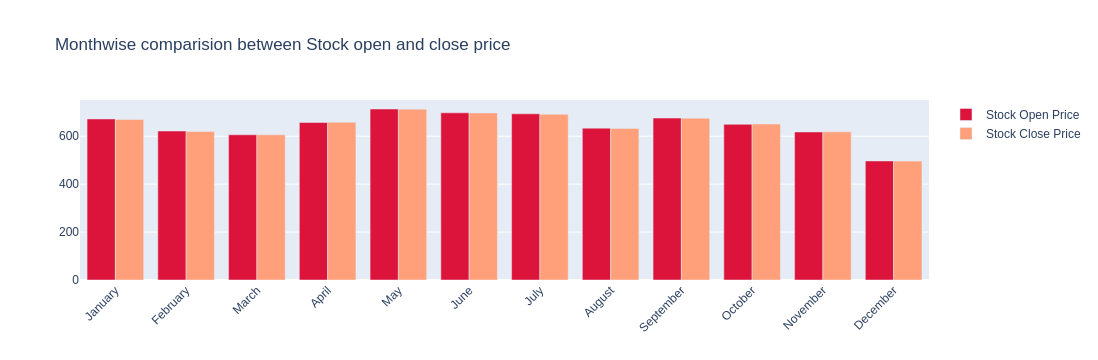

In [180]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

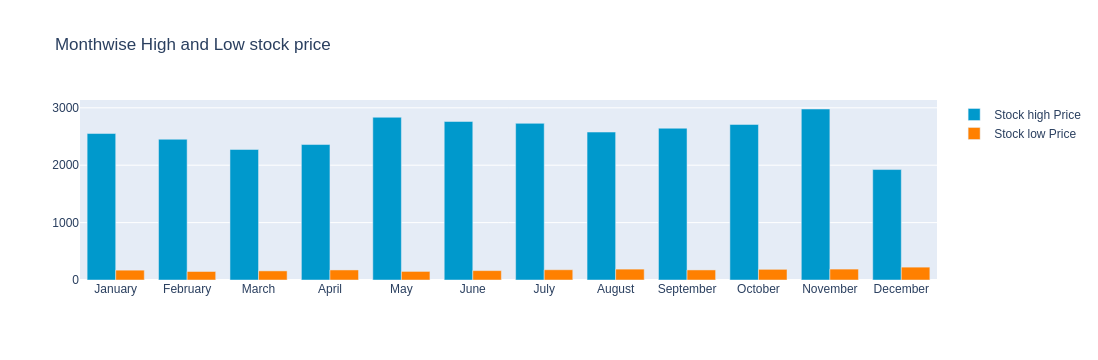

In [181]:
maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_high = maindf.groupby(maindf['date'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

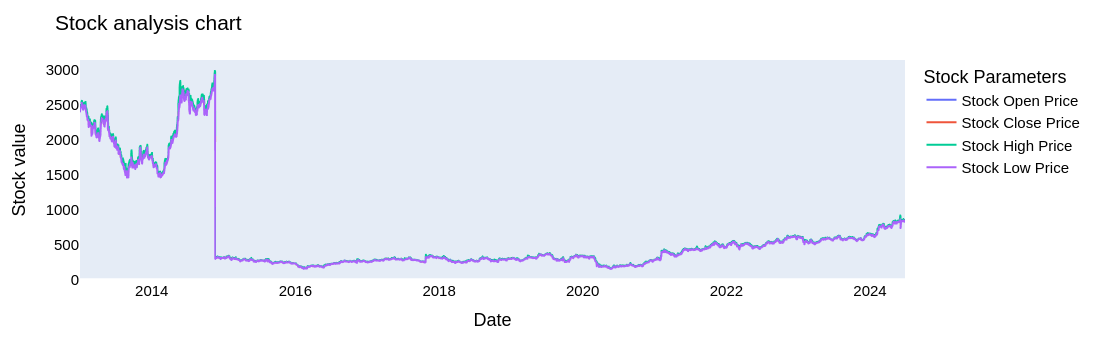

In [182]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(maindf, x=maindf.date, y=[maindf['open'], maindf['close'], 
                                          maindf['high'], maindf['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [183]:
closedf = maindf[['date','close']]

print("Shape of close dataframe:", closedf.shape)


Shape of close dataframe: (2856, 2)


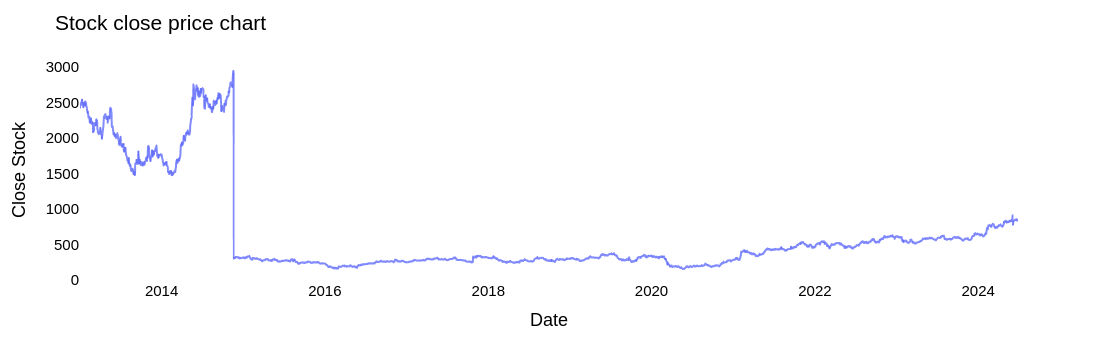

In [184]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [185]:
closedf = maindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2856, 2)


In [186]:
closedf = closedf[closedf['date'] > '2015-01-01']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  2361


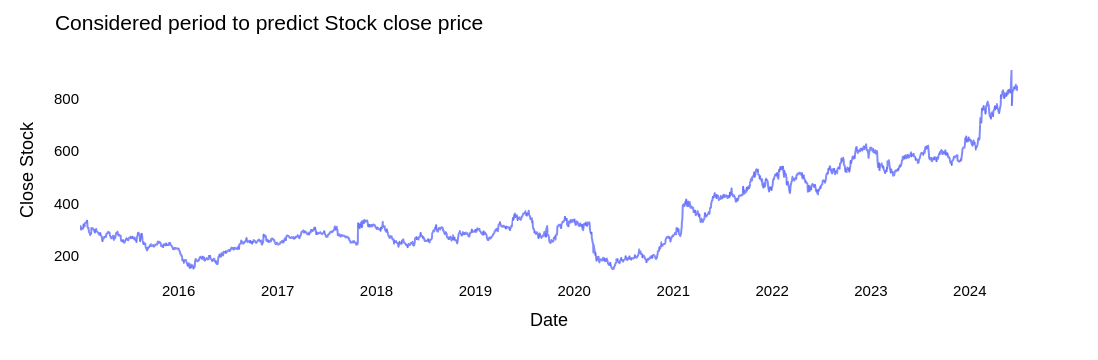

In [187]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [188]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(2361, 1)


In [189]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1416, 1)
test_data:  (945, 1)


In [190]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [191]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1400, 15)
y_train:  (1400,)
X_test:  (929, 15)
y_test (929,)


In [192]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1400, 15, 1)
X_test:  (929, 15, 1)


In [193]:
tf.keras.backend.clear_session()
model=Sequential()
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the model's architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 32)         │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 15, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,065 (62.75 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 0 (0.00 B)

In [194]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0712 - val_loss: 0.0010
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 1.7813e-04
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 2.3597e-04
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 1.6059e-04
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 1.7397e-04
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 3.1155e-04
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 1.4591e-04
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 1.4034e-04
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 1.4882e-04
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - val_loss: 2.0970e-04
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 1.2843e-04
Epoch 12/200

In [195]:
model.save('/home/ariyaman/learntocode/Stockipy/models/Naive_Bayes/SBIN_Model_GRU.keras')

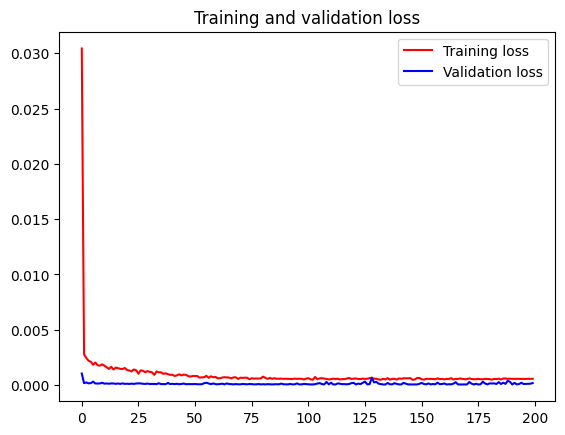

<Figure size 640x480 with 0 Axes>

In [196]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [197]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


((1400, 1), (929, 1))

In [198]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [199]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  10.497464451682621
Train data MSE:  110.19675991434032
Train data MAE:  7.9793816244942795
-------------------------------------------------------------------------------------
Test data RMSE:  10.201963966672913
Test data MSE:  104.08006877729252
Test data MAE:  8.78825406340403


In [200]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9963400979495544
Test data explained variance regression score: 0.9774723240258311


In [201]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9957411862550302
Test data R2 score: 0.9258209632139401


In [202]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0010177936301373875
Test data MGD:  0.0016624875604124563
----------------------------------------------------------------------
Train data MPD:  0.3006031220264922
Test data MPD:  0.4092443365711658


In [203]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2361, 1)
Test predicted data:  (2361, 1)


In [204]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [205]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [206]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

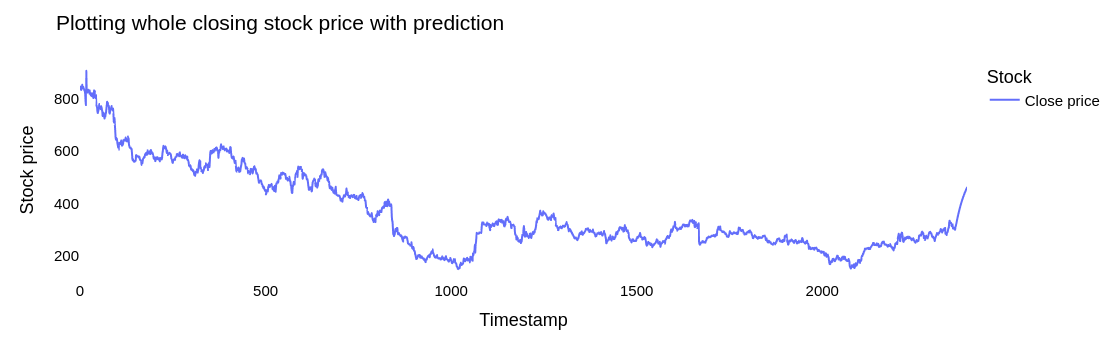

In [207]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()